In [128]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import pandas as pd
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

# generate random normally distributed point clouds (customize as needed)
CFE_coef = np.random.random(671)
LSTM_coef = 1-CFE_coef

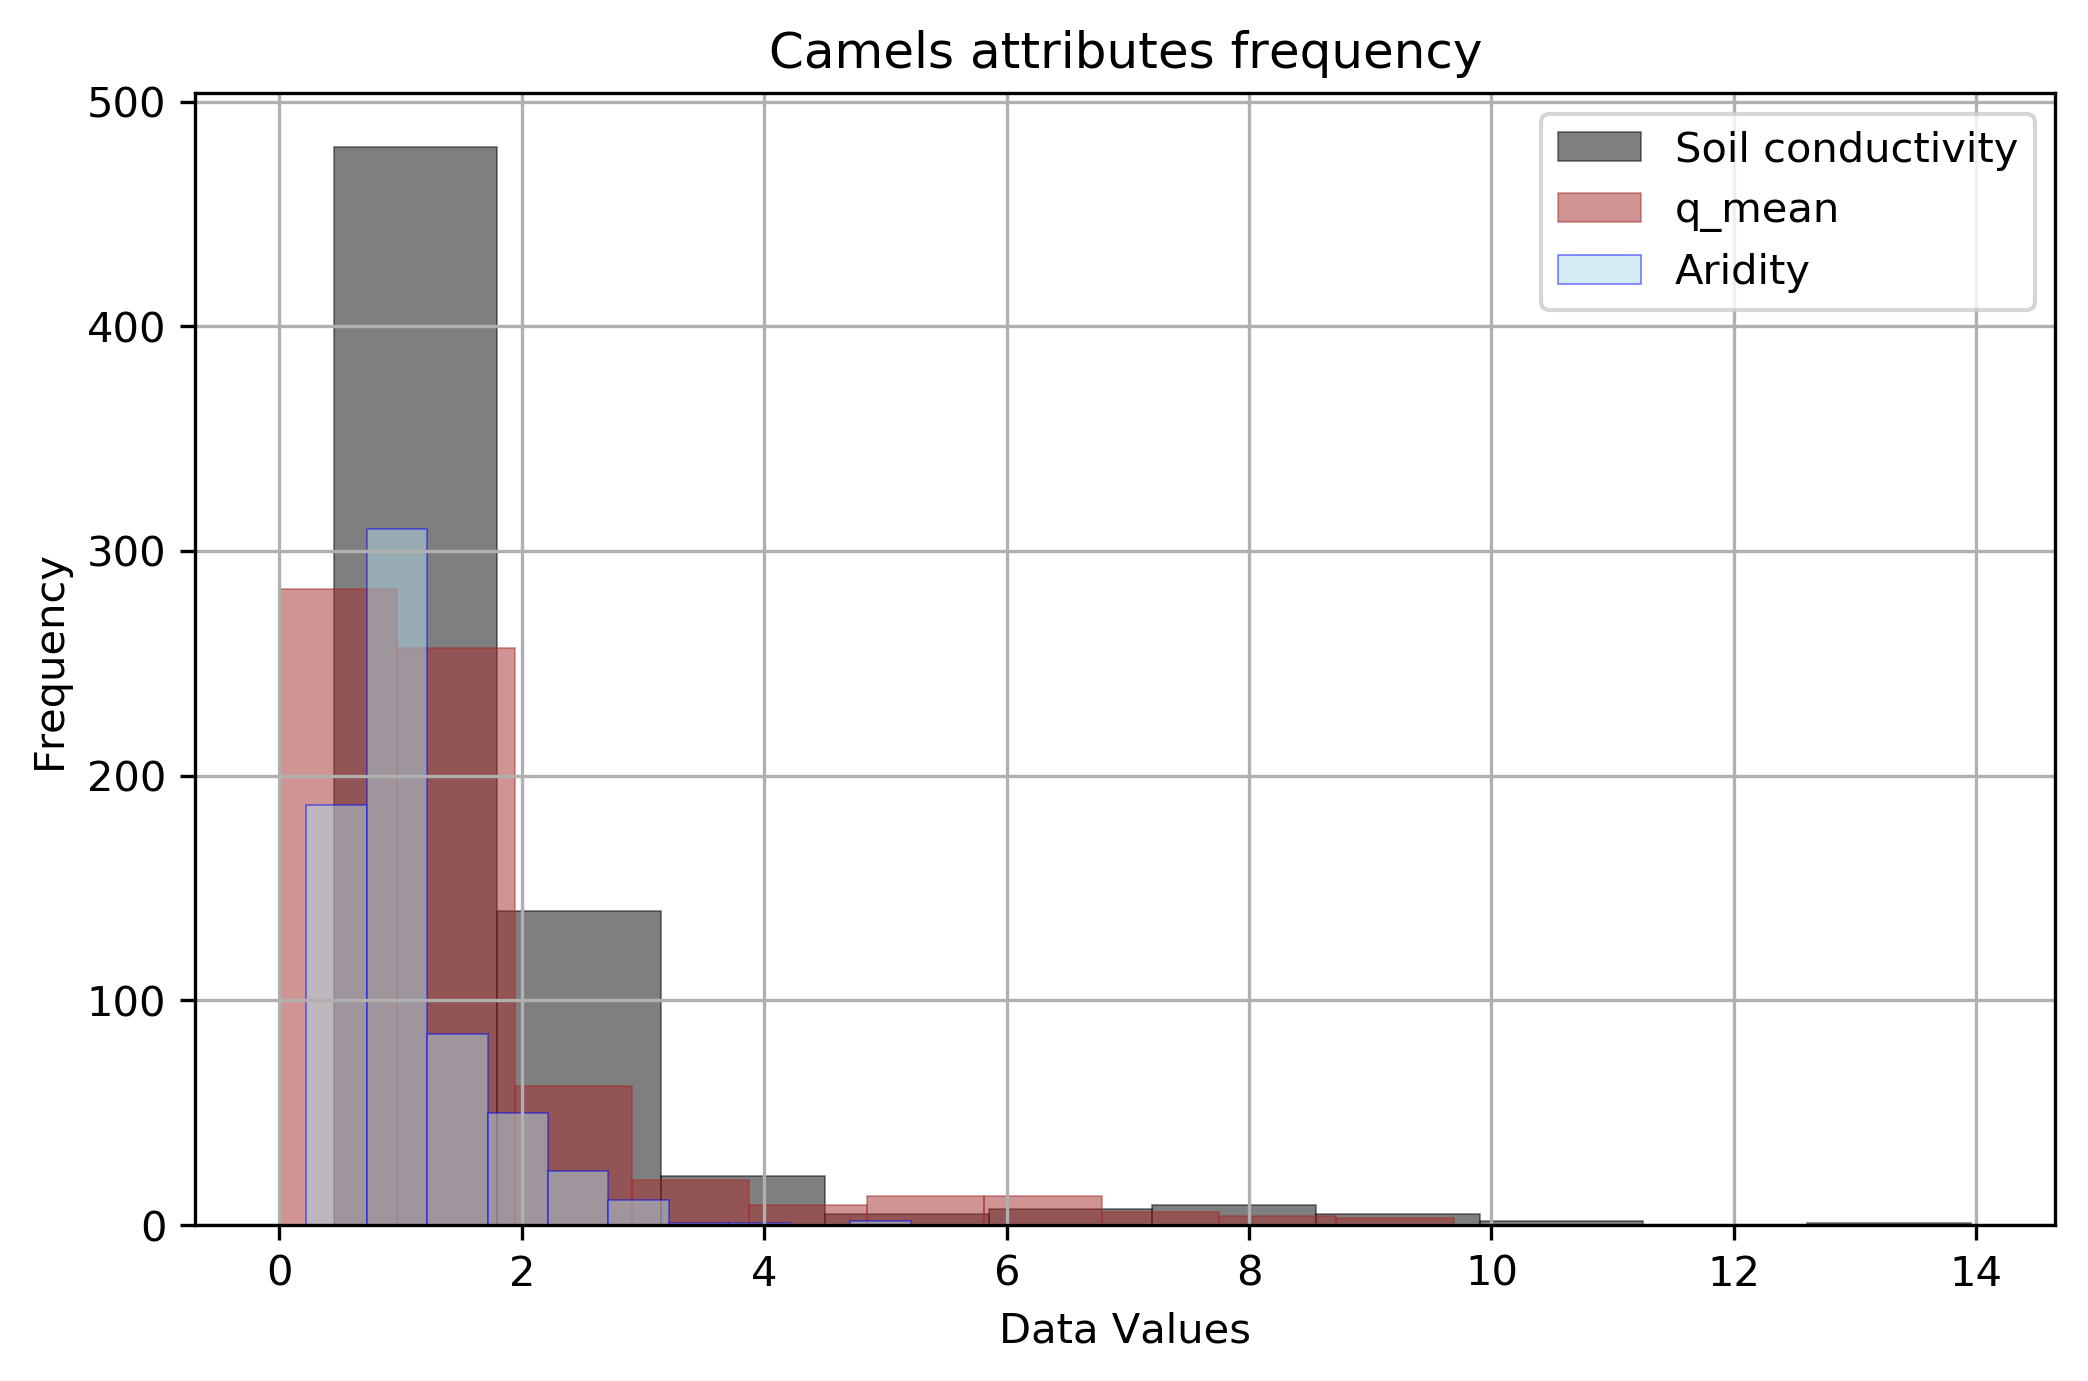

In [153]:
# read text file into pandas DataFrame
df = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_clim.txt", sep=";")
# print(df)
tmp = df.iloc[:,5]# This is aridity
aridity = tmp.values

df = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_hydro.txt", sep=";")
#print(df)
tmp = df.iloc[:,1]# This is q_mean
q_mean = tmp.values

df = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_soil.txt", sep=";")
tmp = df.iloc[:,4]# This is soil conductivity
conductivity = tmp.values

fig = plt.figure(figsize = (8, 5), dpi = 300)

plt.hist(conductivity, color = "k", ec="k", lw=0.4, alpha = 0.5, label='Soil conductivity')
plt.hist(q_mean, color = "Brown", ec="Brown", lw=0.4, alpha = 0.5, label='q_mean')
plt.hist(aridity, color = "lightblue", ec="blue", lw=0.4, alpha = 0.5, label='Aridity')

plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title("Camels attributes frequency")
plt.grid()
plt.legend()

In [163]:
Features_combined = np.vstack((aridity, q_mean, conductivity)).T
combined = np.vstack((CFE_coef, LSTM_coef)).T

In [208]:
no_data = np.argwhere(np.isnan(Features_combined))
print(no_data)
Features_input = np.delete(Features_combined, np.s_[225], 0)
Weights_input = np.delete(combined, np.s_[225], 0)


[[225   1]]


In [209]:
#x = df.drop('p_mean', axis = 1) # Features
x = pd.DataFrame(Features_input,columns=['aridity','q_mean','conductivity'])# Features, only taking a few variables here
y = pd.DataFrame(Weights_input,columns=['CFE_weight','LSTM_weight'])# Target

In [210]:
x.head()

,aridity,q_mean,conductivity
0,0.630559,1.699155,1.106522
1,0.587356,2.173062,2.375005
2,0.624111,1.820108,1.289807
3,0.587950,2.030242,1.373292
4,0.628929,2.182870,2.615154


In [211]:
y.head()

,CFE_weight,LSTM_weight
0,0.354111,0.645889
1,0.757841,0.242159
2,0.714855,0.285145
3,0.010659,0.989341
4,0.278038,0.721962


In [212]:
# Splitting the dataset into training and testing set (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

In [213]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  0.321
